In [82]:
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np
from plotter import Plotter
import dolfin as df
from ffian.project_flow_models import ModelMC1, ModelMC2, ModelMC3, ModelMC4, ModelMC5
import inspect

%matplotlib inline

In [128]:
class PlotObject:
    def __init__(self, model_v, point_time=1.5e-4, n=None):
            
        j_in = 1.0e-6                # input constant (mol/(m^2s))
        Tstop = 60                   # duration of simulation (s)
        stim_start = 10              # stimulus onset (s)
        stim_end = 20                # stimulus offset (s)
        if n is None:
            n = stim_end
        stim_protocol = 'constant'   # stimulus protocol ('constant', 'slow', or 'ultraslow')
        # mesh
        N = 400                                  # mesh size
        L = 3.0e-4                               # m (300 um)
        mesh = df.IntervalMesh(N, 0, L)          # create mesh
        
        # model setup
        t_PDE = df.Constant(0.0)  # time constant
        class_name = f"Model{model_v}"
        if class_name in globals() and inspect.isclass(globals()[class_name]):
            model_type = globals()[class_name]
        model = model_type(model_v, mesh, L, t_PDE, j_in, stim_start, stim_end, stim_protocol)
        self.model = model
        path_data = 'results/data/' + model_v + '/'
        path_figs = 'results/figures/'
        P = Plotter(model, path_data)

        # time variables
        dt_value = 1e-3                          # time step (s)
        
        # get parameters
        K_m = model.params['K_m']
        p_m_init = model.params['p_m_init']
        alpha_i_init = float(model.alpha_i_init)
        alpha_e_init = float(model.alpha_e_init)

        # point in space at which to use in timeplots
        point = point_time

        # range of t values
        xlim_T = [0.0, Tstop]

        # list of function values at point
        j_ins = []
        j_decs = []
        j_pumps = []
        Na_is = []
        K_is = []
        Cl_is = []
        HCO3_is = []
        Na_es = []
        K_es = []
        Cl_es = []
        HCO3_es = []
        dalpha_is = []
        dalpha_es = []
        p_ms = []
        phi_ms = []

        for n in range(Tstop+1):

            # get data
            alpha_i = P.read_from_file(n, 0)
            Na_i = P.read_from_file(n, 1)
            Na_e = P.read_from_file(n, 2)
            K_i = P.read_from_file(n, 3)
            K_e = P.read_from_file(n, 4)
            Cl_i = P.read_from_file(n, 5)
            Cl_e = P.read_from_file(n, 6)
            if model_v == 'MC3' or model_v == 'MC5':
                HCO3_i = P.read_from_file(n, 7)
                HCO3_e = P.read_from_file(n, 8)
                phi_i = P.read_from_file(n, 9)
                phi_e = P.read_from_file(n, 10)
            else:
                phi_i = P.read_from_file(n, 7)
                phi_e = P.read_from_file(n, 8)

            # calculate extracellular volume fraction
            alpha_e = 0.6 - alpha_i(point)

            # get input/decay fluxes
            j_in_ = model.j_in(n)
            j_dec_ = model.j_dec(K_e)
            j_pump_ = model.j_pump(K_e, Na_i)
            j_in = P.project_to_function_space(j_in_*1e6)    # convert to umol/(m^2s)
            j_dec = P.project_to_function_space(j_dec_*1e6)  # convert to umol/(m^2s)
            j_pump = P.project_to_function_space(j_pump_*1e6)# convert to umol/(m^2s)

            # calculate change in volume fractions
            alpha_i_diff = (alpha_i(point) - alpha_i_init)/alpha_i_init*100
            alpha_e_diff = (alpha_e - alpha_e_init)/alpha_e_init*100

            # calculate transmembrane hydrostatic pressure
            tau = K_m*(alpha_i(point) - alpha_i_init)
            p_m = tau + p_m_init

            # calculate membrane potential
            phi_m = (phi_i(point) - phi_e(point))*1000  # convert to mV

            # append data to lists
            j_ins.append(j_in(point))
            j_decs.append(j_dec(point))
            j_pumps.append(j_pump(point))
            Na_is.append(Na_i(point))
            K_is.append(K_i(point))
            Cl_is.append(Cl_i(point))
            Na_es.append(Na_e(point))
            K_es.append(K_e(point))
            Cl_es.append(Cl_e(point))
            if model_v == 'MC3' or model_v == 'MC5':
                HCO3_is.append(HCO3_i(point))
                HCO3_es.append(HCO3_e(point))
            dalpha_is.append(alpha_i_diff)
            dalpha_es.append(alpha_e_diff)
            p_ms.append(float(p_m))
            phi_ms.append(phi_m)
        
        if model_v == 'MC3' or model_v == 'MC5':
            self.HCO3_is = HCO3_is
            self.HCO3_es = HCO3_es
        self.j_in = j_ins
        self.j_dec = j_decs
        self.dalpha_i = dalpha_is
        self.dalpha_e = dalpha_es
        self.Na_i = Na_is
        self.Na_e = Na_es
        self.K_i = K_is
        self.K_e = K_es
        self.Cl_i = Cl_is
        self.Cl_e = Cl_es
        self.p_m = p_ms
        self.phi_m = phi_ms
        self.j_pump = j_pumps

        n = stim_end
        
        # SPACEPLOTS
        # get data
        alpha_i_ = P.read_from_file(n, 0)
        Na_i_ = P.read_from_file(n, 1)
        Na_e_ = P.read_from_file(n, 2)
        K_i_ = P.read_from_file(n, 3)
        K_e_ = P.read_from_file(n, 4)
        Cl_i_ = P.read_from_file(n, 5)
        Cl_e_ = P.read_from_file(n, 6)
        if model_v == 'MC3' or model_v == 'MC5':
            HCO3_i_ = P.read_from_file(n, 7)
            HCO3_e_ = P.read_from_file(n, 8)
            phi_i_ = P.read_from_file(n, 9)
            phi_e_ = P.read_from_file(n, 10)
        else:
            phi_i_ = P.read_from_file(n, 7)
            phi_e_ = P.read_from_file(n, 8)

        # calculate extracellular volume fraction
        alpha_e_ = 0.6 - alpha_i_

        # get input/decay fluxes
        j_in_ = model.j_in(n)
        j_dec_ = model.j_dec(K_e_)

        # calculate transmembrane hydrostatic pressure
        tau = K_m*(alpha_i_ - alpha_i_init)
        p_m = tau + p_m_init

        # calculate membrane potential
        phi_m_ = (phi_i_ - phi_e_)*1000  # convert to mV

        # changes from baseline
        dalpha_i_ = (alpha_i_ - alpha_i_init)/alpha_i_init*100
        dalpha_e_ = (alpha_e_ - alpha_e_init)/alpha_e_init*100
        dNa_i_ = Na_i_ - float(model.Na_i_init)
        dNa_e_ = Na_e_ - float(model.Na_e_init)
        dK_i_ = K_i_ - float(model.K_i_init)
        dK_e_ = K_e_ - float(model.K_e_init)
        dCl_i_ = Cl_i_ - float(model.Cl_i_init)
        dCl_e_ = Cl_e_ - float(model.Cl_e_init)
        if model_v == 'MC3' or model_v == 'MC5':
            dHCO3_i_ = HCO3_i_ - float(model.HCO3_i_init)
            dHCO3_e_ = HCO3_e_ - float(model.HCO3_e_init)
        dp_m_ = p_m - p_m_init

        # project to function space
        self.j_in_space = P.project_to_function_space(j_in_*1e6)    # convert to umol/(m^2s)
        self.j_dec_space = P.project_to_function_space(j_dec_*1e6)  # convert to umol/(m^2s)
        self.dalpha_i_space = P.project_to_function_space(dalpha_i_)
        self.dalpha_e_space = P.project_to_function_space(dalpha_e_)
        self.dNa_i = P.project_to_function_space(dNa_i_)
        self.dNa_e = P.project_to_function_space(dNa_e_)
        self.dK_i = P.project_to_function_space(dK_i_)
        self.dK_e = P.project_to_function_space(dK_e_)
        self.dCl_i = P.project_to_function_space(dCl_i_)
        self.dCl_e = P.project_to_function_space(dCl_e_)
        if model_v == 'MC3' or model_v == 'MC5':
            self.dHCO3_i = P.project_to_function_space(dHCO3_i_)
            self.dHCO3_e = P.project_to_function_space(dHCO3_e_)
        self.dp_m = P.project_to_function_space(dp_m_)
        self.phi_m_space = P.project_to_function_space(phi_m_)
        
        temperature = model.params['temperature']
        R = model.params['R']
        a_i = model.params['a'][0]
        kappa = model.params['kappa']
        eps_r = model.params['eps_r']
        eps_zero = model.params['eps_zero']
        zeta = model.params['zeta']
        mu = model.params['mu']
        K_m = model.params['K_m']
        p_m_init = model.params['p_m_init']

        alpha_i = P.read_from_file(n, 0)
        if model_v == 'MC3' or model_v == 'MC5':
            phi_e = P.read_from_file(n, 10)
            p_e = P.read_from_file(n, 11)
        else:
            phi_e = P.read_from_file(n, 8)
            p_e = P.read_from_file(n, 9)

        # extracellular volume fraction
        alpha_e = 0.6 - alpha_i

        # intracellular hydrostatic pressure
        tau = K_m*(alpha_i - float(model.alpha_i_init))
        p_i = p_e + tau + p_m_init

        # ICS fluid velocities
        u_i_hyd_ = - kappa[0]*df.grad(p_i)
        u_i_osm_ = kappa[0]*R*temperature*df.grad(a_i/alpha_i)
        u_i_tot_ = u_i_hyd_[0] + u_i_osm_[0]

        # ECS fluid velocities
        u_e_hyd_ = - kappa[1]*df.grad(p_e)
        u_e_eof_ = - eps_r*eps_zero*zeta*df.grad(phi_e)/mu
        u_e_tot_ = u_e_hyd_[0] + u_e_eof_[0]

        # project to function space
        self.u_i_hyd = P.project_to_function_space(alpha_i*u_i_hyd_[0]*1.0e6*60)  # convert to um/min
        self.u_i_osm = P.project_to_function_space(alpha_i*u_i_osm_[0]*1.0e6*60)
        self.u_i_tot = P.project_to_function_space(alpha_i*u_i_tot_*1.0e6*60)
        self.u_e_hyd = P.project_to_function_space(alpha_e*u_e_hyd_[0]*1.0e6*60)
        self.u_e_eof = P.project_to_function_space(alpha_e*u_e_eof_[0]*1.0e6*60)
        self.u_e_tot = P.project_to_function_space(alpha_e*u_e_tot_*1.0e6*60)

In [129]:
MC1 = PlotObject('MC1')
MC2 = PlotObject('MC2')
MC3 = PlotObject('MC3')
MC4 = PlotObject('MC4')
MC5 = PlotObject('MC5')

In [130]:
# set font & text parameters
font = {'family': 'serif',
        'weight': 'bold',
        'size': 16}
plt.rc('font', **font)
plt.rc('text', usetex=True)
mpl.rcParams['image.cmap'] = 'jet'
plt.rc('legend')
plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')

# set colors
colormap = cm.viridis
mus = [1, 2, 3, 4, 5, 6]
colorparams = mus
colormap = cm.viridis
normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))

b0 = '#7fc97fff'
b1 = '#beaed4ff'
b2 = '#fdc086ff'
b3 = '#ffff99ff'
b4 = '#386cb0ff'

color_list = [b0, b1, b2, b3, b4]

c2 = colormap(normalize(mus[0]))
c1 = colormap(normalize(mus[1]))
c0 = colormap(normalize(mus[2]))
c3 = colormap(normalize(mus[3]))
c4 = colormap(normalize(mus[4]))
c5 = colormap(normalize(mus[5]))
colors = [c1, c2, c3, c4, c5]

# plotting parameters
xlim = [0, 3e-4]  # range of x values (m)
xticks = [0e-3, 0.05e-3, 0.1e-3, 0.15e-3, 0.2e-3, 0.25e-3, 0.3e-3]
xticklabels = ['0', '50', '100', '150', '200', '250', '300']
xlabel_x = '$x$ (um)'
point_time = 1.5e-4

lw = 2 #4.5     # line width
fosi = 18.7  # ylabel font size
fs = 0.9

mpl.rcParams['figure.dpi'] = 150

# Begin here to make plots!
You only need to modify the cell right below this.

## Step 1
Add the variables you want to plot to the plot_list. This can be any number of variables from 1 to 4. The limiting factor to this is the colors but if you expand the color_list you can add more lines to one plot. You can also perform arithmetic operations on these variables (the one shown below is for the change in concentration of intracellular Na).

The variable naming for ion concentrations is ion followed by underscore i for intracellular or e for extracellular. Flux variables are j_in, j_dec, j_pump. Area change variables are d_alphai and d_alphae.

## Step 2
Change the ylabel and xlabels.

## Step 3
Add a legend entry for each line. Leave empty if you are plotting only one variable.

### Create your plot lists for different ionic species here:

In [123]:
plot_list_Nai = [MC1.Na_i - MC1.Na_i[0], MC2.Na_i - MC2.Na_i[0], MC3.Na_i - MC3.Na_i[0], MC4.Na_i - MC4.Na_i[0], MC5.Na_i - MC5.Na_i[0]]
plot_list_Nae = [MC1.Na_e - MC1.Na_e[0], MC2.Na_e - MC2.Na_e[0], MC3.Na_e - MC3.Na_e[0], MC4.Na_e - MC4.Na_e[0], MC5.Na_e - MC5.Na_e[0]]

plot_list_Ki = [MC1.K_i - MC1.K_i[0], MC2.K_i - MC2.K_i[0], MC3.K_i - MC3.K_i[0], MC4.K_i - MC4.K_i[0], MC5.K_i - MC5.K_i[0]]
plot_list_Ke = [MC1.K_e - MC1.K_e[0], MC2.K_e - MC2.K_e[0], MC3.K_e - MC3.K_e[0], MC4.K_e - MC4.K_e[0], MC5.K_e - MC5.K_e[0]]

#make the same but for Cl_i and Cl_e
plot_list_Cli = [MC1.Cl_i - MC1.Cl_i[0], MC2.Cl_i - MC2.Cl_i[0], MC3.Cl_i - MC3.Cl_i[0], MC4.Cl_i - MC4.Cl_i[0], MC5.Cl_i - MC5.Cl_i[0]]
plot_list_Cle = [MC1.Cl_e - MC1.Cl_e[0], MC2.Cl_e - MC2.Cl_e[0], MC3.Cl_e - MC3.Cl_e[0], MC4.Cl_e - MC4.Cl_e[0], MC5.Cl_e - MC5.Cl_e[0]]

plot_list_HCO3_is = [MC3.HCO3_is - MC3.HCO3_is[0], MC5.HCO3_is - MC5.HCO3_is[0]]
plot_list_HCO3_es = [MC3.HCO3_es - MC3.HCO3_es[0], MC5.HCO3_es - MC5.HCO3_es[0]]


#### Plot the ionic concentrations: 

##### Sodium:

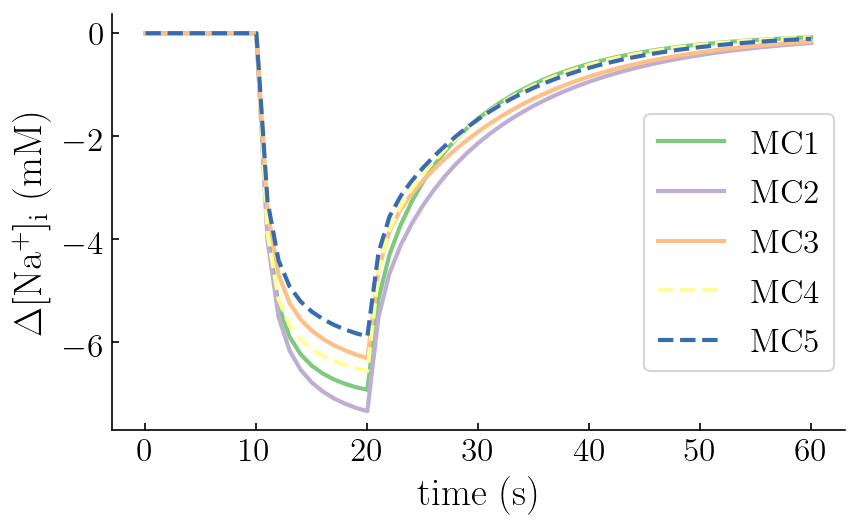

In [93]:
ylabel = r'$\Delta [\mathrm{Na^{+}}]_\mathrm{i}$ (mM)'
xlabel = r'time (s)'
legend = [r'MC1', r'MC2', r'MC3', r'MC4', r'MC5']

fig = plt.figure(figsize=(7*fs, 4*fs))
ax = plt.gca()
for i, line in enumerate(plot_list_Nai):
    linestyle = '--' if i == 3 or i == 4  else '-'
    plt.plot(line, color=color_list[i], label=legend[i], linestyle = linestyle, linewidth=lw)
if len(plot_list_Nai) > 1:
    plt.figlegend(bbox_to_anchor=(0.9, 0.8), frameon=True)

plt.xlabel(xlabel, fontsize=fosi)
plt.ylabel(ylabel, fontsize=fosi)
# make pretty
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

figname = 'mc1vmc5_deltaNai'
#save fig as pdf 
fig.savefig('results/figures/' + figname + '.pdf', format='pdf', bbox_inches='tight')

##### Sodium extracellular: 

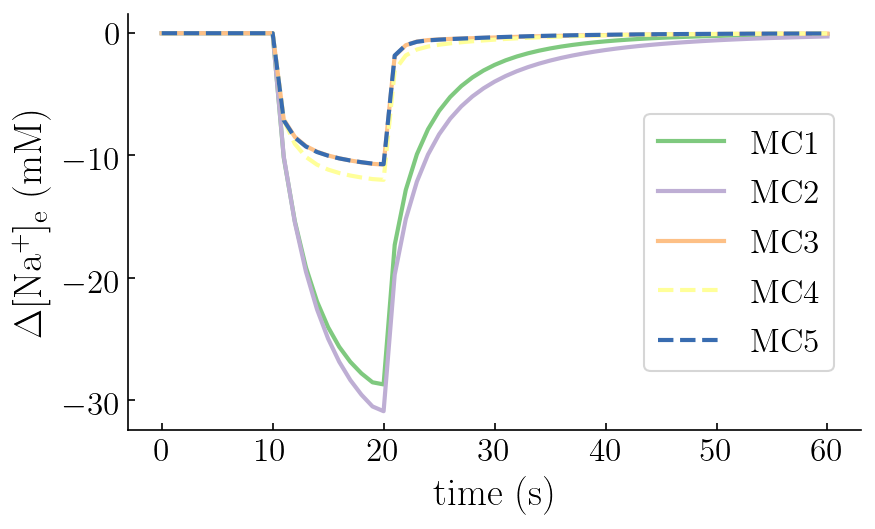

In [95]:
ylabel = r'$\Delta [\mathrm{Na^{+}}]_\mathrm{e}$ (mM)'
xlabel = r'time (s)'
legend = [r'MC1', r'MC2', r'MC3', r'MC4', r'MC5']

fig = plt.figure(figsize=(7*fs, 4*fs))
ax = plt.gca()
for i, line in enumerate(plot_list_Nae):
    linestyle = '--' if i == 3 or i == 4  else '-'
    plt.plot(line, color=color_list[i], label=legend[i], linestyle = linestyle, linewidth=lw)
if len(plot_list_Nae) > 1:
    plt.figlegend(bbox_to_anchor=(0.9, 0.8), frameon=True)

plt.xlabel(xlabel, fontsize=fosi)
plt.ylabel(ylabel, fontsize=fosi)
# make pretty
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

figname = 'mc1vmc5_deltaNae'
#save fig as pdf 
fig.savefig('results/figures/' + figname + '.pdf', format='pdf', bbox_inches='tight')

##### Potassium intracellular 

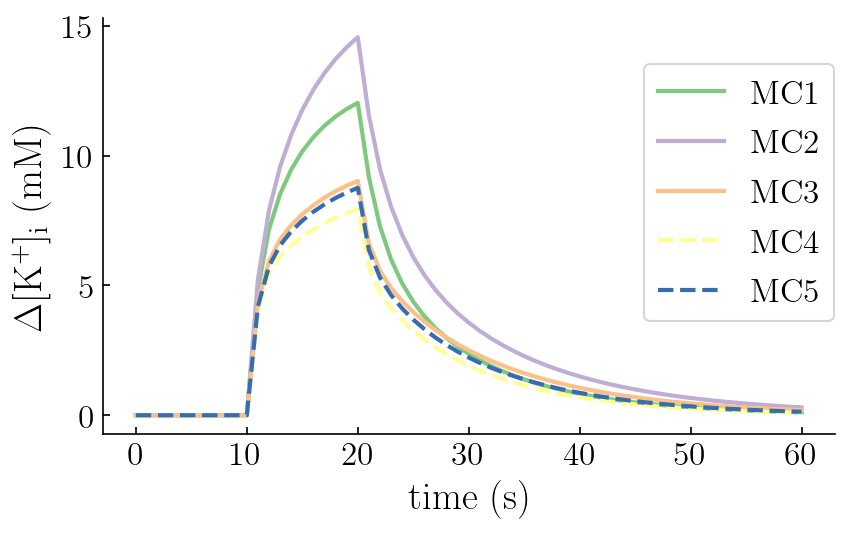

In [96]:
ylabel = r'$\Delta [\mathrm{K^{+}}]_\mathrm{i}$ (mM)'
xlabel = r'time (s)'
legend = [r'MC1', r'MC2', r'MC3', r'MC4', r'MC5']

fig = plt.figure(figsize=(7*fs, 4*fs))
ax = plt.gca()
for i, line in enumerate(plot_list_Ki):
    linestyle = '--' if i == 3 or i == 4  else '-'
    plt.plot(line, color=color_list[i], label=legend[i], linestyle = linestyle, linewidth=lw)
if len(plot_list_Ki) > 1:
    plt.figlegend(bbox_to_anchor=(0.9, 0.9), frameon=True)

plt.xlabel(xlabel, fontsize=fosi)
plt.ylabel(ylabel, fontsize=fosi)
# make pretty
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

figname = 'mc1vmc5_deltaKi'
#save fig as pdf 
fig.savefig('results/figures/' + figname + '.pdf', format='pdf', bbox_inches='tight')

##### Potassium extracellular

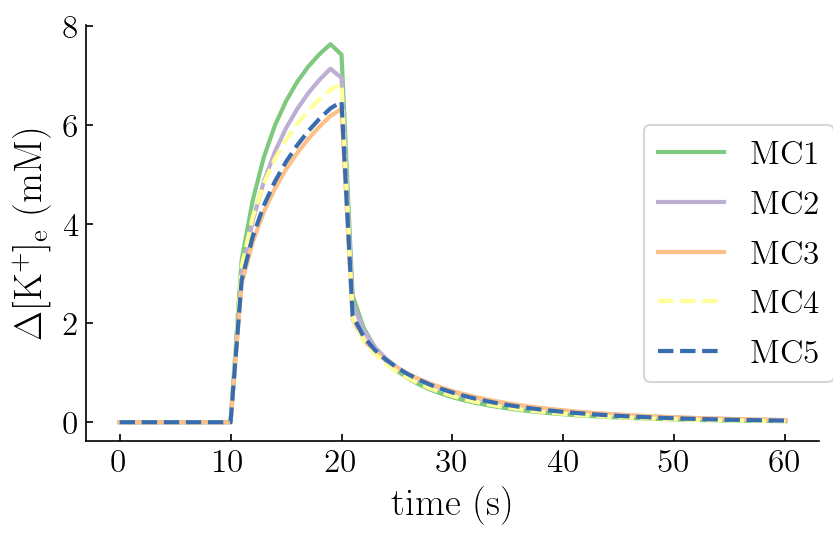

In [97]:
ylabel = r'$\Delta [\mathrm{K^{+}}]_\mathrm{e}$ (mM)'
xlabel = r'time (s)'
legend = [r'MC1', r'MC2', r'MC3', r'MC4', r'MC5']

fig = plt.figure(figsize=(7*fs, 4*fs))
ax = plt.gca()
for i, line in enumerate(plot_list_Ke):
    linestyle = '--' if i == 3 or i == 4  else '-'
    plt.plot(line, color=color_list[i], label=legend[i], linestyle = linestyle, linewidth=lw)
if len(plot_list_Ke) > 1:
    plt.figlegend(bbox_to_anchor=(0.9, 0.8), frameon=True)

plt.xlabel(xlabel, fontsize=fosi)
plt.ylabel(ylabel, fontsize=fosi)
# make pretty
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

figname = 'mc1vmc5_deltaKe'
#save fig as pdf 
fig.savefig('results/figures/' + figname + '.pdf', format='pdf', bbox_inches='tight')

##### Sodium intracellular 

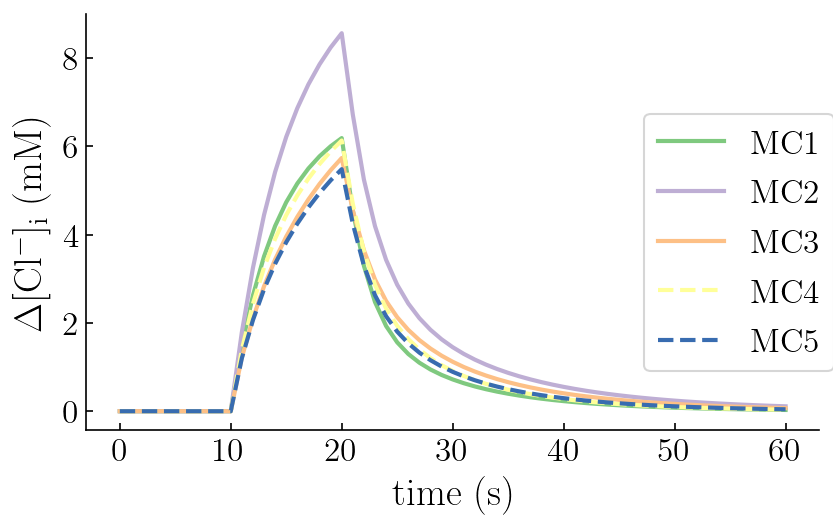

In [98]:
ylabel = r'$\Delta [\mathrm{Cl^{-}}]_\mathrm{i}$ (mM)'
xlabel = r'time (s)'
legend = [r'MC1', r'MC2', r'MC3', r'MC4', r'MC5']

fig = plt.figure(figsize=(7*fs, 4*fs))
ax = plt.gca()
for i, line in enumerate(plot_list_Cli):
    linestyle = '--' if i == 3 or i == 4  else '-'
    plt.plot(line, color=color_list[i], label=legend[i], linestyle = linestyle, linewidth=lw)
if len(plot_list_Cli) > 1:
    plt.figlegend(bbox_to_anchor=(0.9, 0.8), frameon=True)

plt.xlabel(xlabel, fontsize=fosi)
plt.ylabel(ylabel, fontsize=fosi)
# make pretty
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

figname = 'mc1vmc5_deltaCli'
#save fig as pdf 
fig.savefig('results/figures/' + figname + '.pdf', format='pdf', bbox_inches='tight')

##### Sodium extracellular 

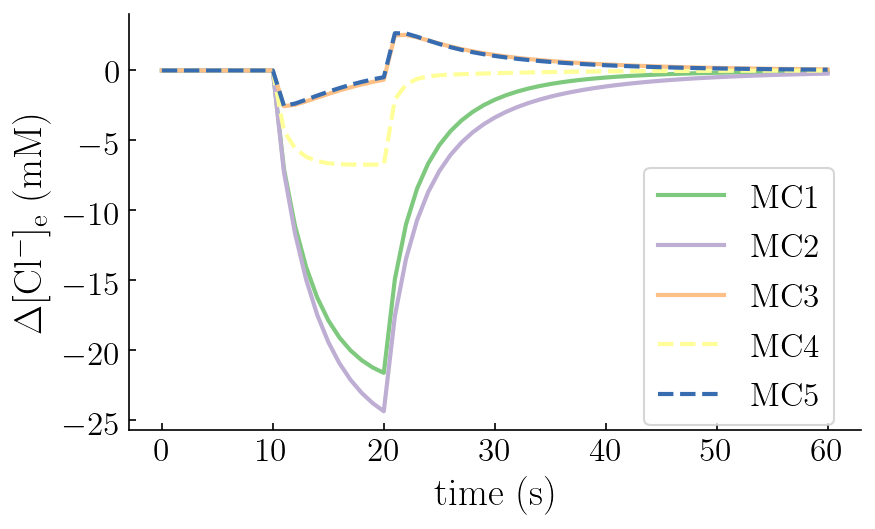

In [99]:
ylabel = r'$\Delta [\mathrm{Cl^{-}}]_\mathrm{e}$ (mM)'
xlabel = r'time (s)'
legend = [r'MC1', r'MC2', r'MC3', r'MC4', r'MC5']

fig = plt.figure(figsize=(7*fs, 4*fs))
ax = plt.gca()
for i, line in enumerate(plot_list_Cle):
    linestyle = '--' if i == 3 or i == 4  else '-'
    plt.plot(line, color=color_list[i], label=legend[i], linestyle = linestyle, linewidth=lw)
if len(plot_list_Cle) > 1:
    plt.figlegend(bbox_to_anchor=(0.9, 0.7), frameon=True)

plt.xlabel(xlabel, fontsize=fosi)
plt.ylabel(ylabel, fontsize=fosi)
# make pretty
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

figname = 'mc1vmc5_deltaCle'
#save fig as pdf 
fig.savefig('results/figures/' + figname + '.pdf', format='pdf', bbox_inches='tight')

##### Bicarbonate intracellular 

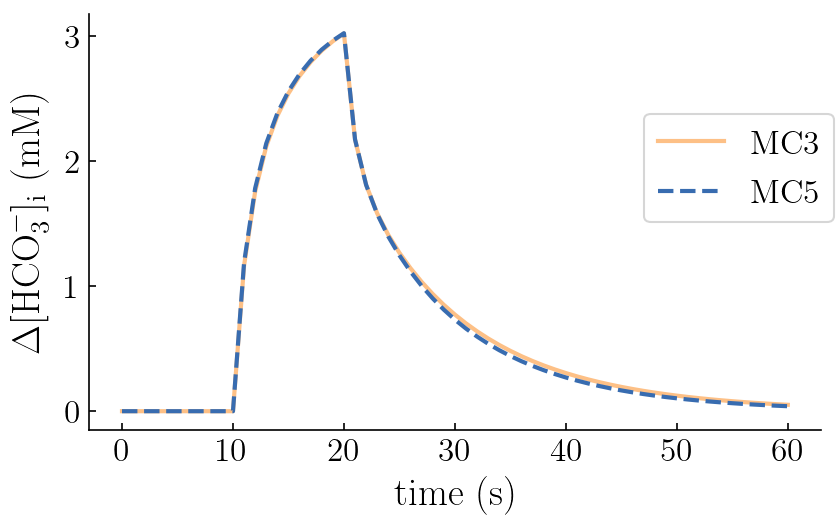

In [100]:
ylabel = r'$\Delta [\mathrm{HCO}_{3}^{-}]_\mathrm{i}$ (mM)'
xlabel = r'time (s)'
legend = [r'MC3', r'MC5']
color_list = [b2, b4]


fig = plt.figure(figsize=(7*fs, 4*fs))
ax = plt.gca()
for i, line in enumerate(plot_list_HCO3_is):
    linestyle = '--' if i == 1  else '-'
    plt.plot(line, color=color_list[i], label=legend[i], linestyle = linestyle, linewidth=lw)
if len(plot_list_Cle) > 1:
    plt.figlegend(bbox_to_anchor=(0.9, 0.8), frameon=True)

plt.xlabel(xlabel, fontsize=fosi)
plt.ylabel(ylabel, fontsize=fosi)
# make pretty
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

figname = 'mc1vmc5_deltaHCO3i'
#save fig as pdf 
fig.savefig('results/figures/' + figname + '.pdf', format='pdf', bbox_inches='tight')

##### Bicarbonate extracellular

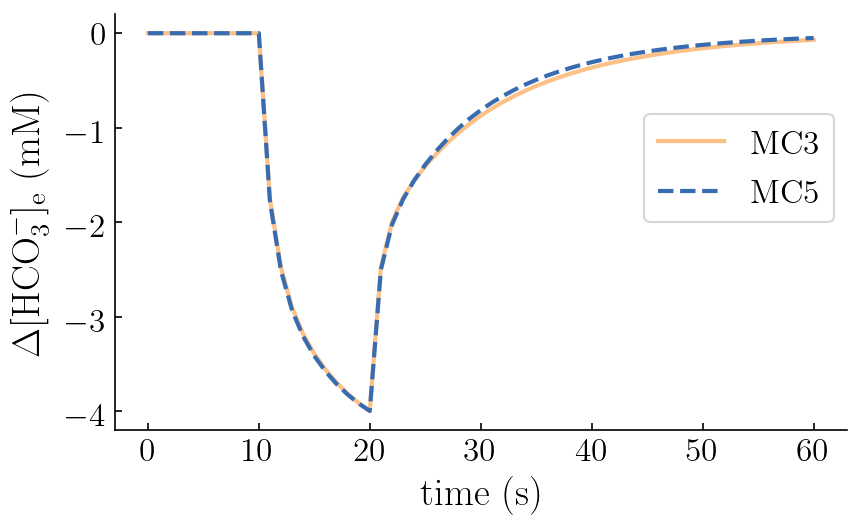

In [101]:
ylabel = r'$\Delta [\mathrm{HCO}_{3}^{-}]_\mathrm{e}$ (mM)'
xlabel = r'time (s)'
legend = [r'MC3', r'MC5']
color_list = [b2, b4]


fig = plt.figure(figsize=(7*fs, 4*fs))
ax = plt.gca()
for i, line in enumerate(plot_list_HCO3_es):
    linestyle = '--' if i == 1  else '-'
    plt.plot(line, color=color_list[i], label=legend[i], linestyle = linestyle, linewidth=lw)
if len(plot_list_Cle) > 1:
    plt.figlegend(bbox_to_anchor=(0.9, 0.8), frameon=True)

plt.xlabel(xlabel, fontsize=fosi)
plt.ylabel(ylabel, fontsize=fosi)
# make pretty
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

figname = 'mc1vmc5_deltaHCO3e'
#save fig as pdf 
fig.savefig('results/figures/' + figname + '.pdf', format='pdf', bbox_inches='tight')

## Volume fraction plots

##### Intracellular volume fraction

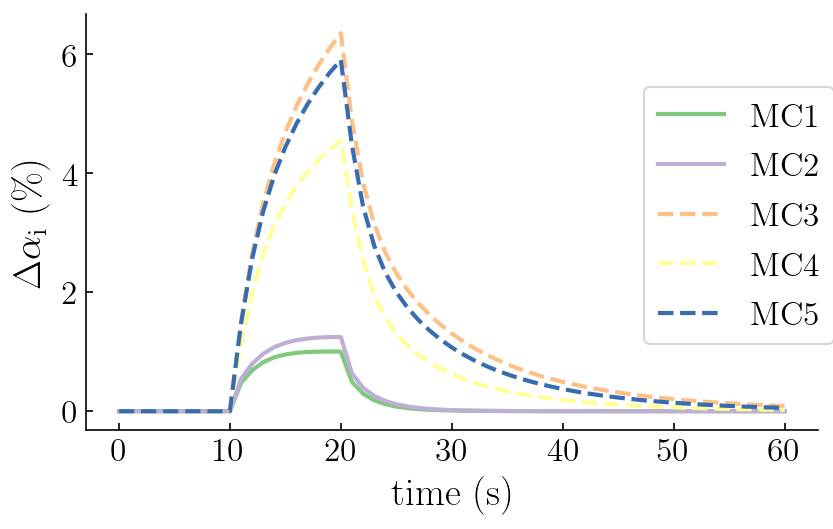

In [108]:
#follow the same procedure: make lists with data you want to plot for each model 

plot_list_dalphai = [MC1.dalpha_i,  MC2.dalpha_i,  MC3.dalpha_i,  MC4.dalpha_i,  MC5. dalpha_i]
plot_list_dalphae = [MC1.dalpha_e,  MC2.dalpha_e,  MC3.dalpha_e,  MC4.dalpha_e,  MC5. dalpha_e]

color_list = [b0, b1, b2, b3, b4]
ylabel = r'$\Delta \mathrm{\alpha}_\mathrm{i}$ (\%)'
xlabel = r'time (s)'
legend = [r'MC1', r'MC2', r'MC3', r'MC4', r'MC5']

fig = plt.figure(figsize=(7*fs, 4*fs))
ax = plt.gca()
for i, line in enumerate(plot_list_dalphai):
    linestyle = '--' if i == 2 or i == 3 or i==4  else '-'
    plt.plot(line, color=color_list[i], label=legend[i], linestyle = linestyle, linewidth=lw)
if len(plot_list_dalphai) > 1:
    plt.figlegend(bbox_to_anchor=(0.9, 0.85), frameon=True)

plt.xlabel(xlabel, fontsize=fosi)
plt.ylabel(ylabel, fontsize=fosi)
# make pretty
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

figname = 'mc1vmc5_delta_alpha_i'
#save fig as pdf 
fig.savefig('results/figures/' + figname + '.pdf', format='pdf', bbox_inches='tight')


##### Extracellular volume fraction

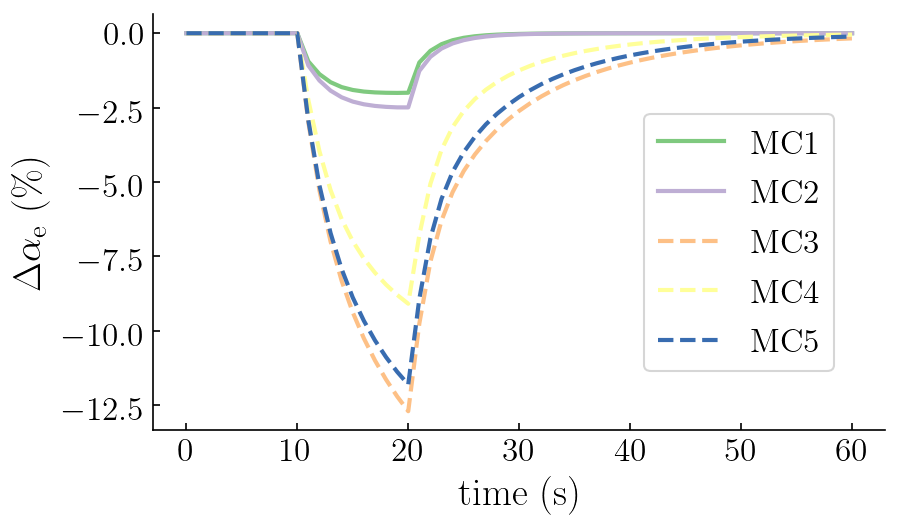

In [109]:

ylabel = r'$\Delta \mathrm{\alpha}_\mathrm{e}$ (\%)'
xlabel = r'time (s)'
legend = [r'MC1', r'MC2', r'MC3', r'MC4', r'MC5']

fig = plt.figure(figsize=(7*fs, 4*fs))
ax = plt.gca()
for i, line in enumerate(plot_list_dalphae):
    linestyle = '--' if i == 2 or i == 3 or i==4  else '-'
    plt.plot(line, color=color_list[i], label=legend[i], linestyle = linestyle,  linewidth=lw)
if len(plot_list_dalphai) > 1:
    plt.figlegend(bbox_to_anchor=(0.9, 0.8), frameon=True)

plt.xlabel(xlabel, fontsize=fosi)
plt.ylabel(ylabel, fontsize=fosi)
# make pretty
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

figname = 'mc1vmc5_delta_alpha_e'
#save fig as pdf 
fig.savefig('results/figures/' + figname + '.pdf', format='pdf', bbox_inches='tight')


## Spaceplots and water velocity!
Add the plots you want to the list and the corresponding x and y labels. The spacedata is setup as $d[k]\_i$ for all the ions and $dp\_m$. The rest have $\_space$ such as $phi\_m\_space$, $j\_in\_space$ and $dalpha\_e\_space$.

The water velocities are saved as $u_i/e_

In [131]:
plot_list_dNai = [MC1.dNa_i, MC2.dNa_i, MC3.dNa_i, MC4.dNa_i, MC5.dNa_i]
plot_list_dNae = [MC1.dNa_e, MC2.dNa_e, MC3.dNa_e, MC4.dNa_e, MC5.dNa_e]

plot_list_dKi = [MC1.dK_i, MC2.dK_i, MC3.dK_i, MC4.dK_i, MC5.dK_i]
plot_list_dKe = [MC1.dK_e, MC2.dK_e, MC3.dK_e, MC4.dK_e, MC5.dK_e]

plot_list_dCli = [MC1.dCl_i, MC2.dCl_i, MC3.dCl_i, MC4.dCl_i, MC5.dCl_i]
plot_list_dCle = [MC1.dCl_e, MC2.dCl_e, MC3.dCl_e, MC4.dCl_e, MC5.dCl_e]

plot_list_dHCO3i = [MC3.dHCO3_i, MC5.dHCO3_i]
plot_list_dHCO3e = [MC3.dHCO3_e, MC5.dHCO3_e]


##### Intracellular space plots for all ionic species (same order as temporal plots)

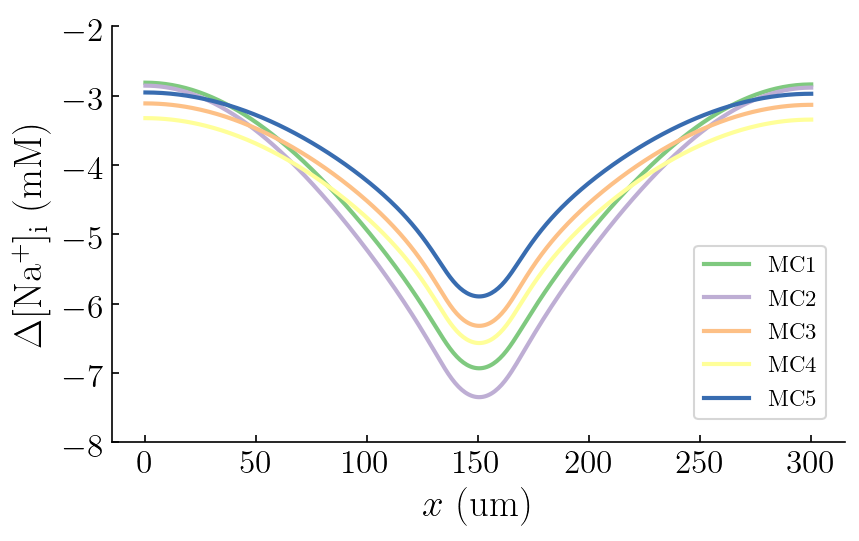

In [134]:
ylabel = r'$\Delta [\mathrm{Na^{+}}]_\mathrm{i}$ (mM)'
legend = ['MC1', 'MC2', 'MC3', 'MC4', 'MC5']

fig = plt.figure(figsize=(7*fs, 4*fs))
ax = plt.gca()
for i, line in enumerate(plot_list_dNai):
    df.plot(line, color=color_list[i], label=legend[i], linewidth=lw)
if len(plot_list_dNai) > 1:
    legend = plt.legend(loc='upper right', prop={'size': 11})  # Adjust the legend's font size
    legend.set_bbox_to_anchor((0.99, 0.5))  # Adjust the legend's position
    legend.set_frame_on(True)  # Turn the legend's frame on
    # plt.figlegend(bbox_to_anchor=(0.9, 0.65), frameon=True)
plt.ylim([-8, -2])
plt.xticks(xticks, xticklabels)
plt.ylabel(ylabel, fontsize=fosi)
plt.xlabel(xlabel_x, fontsize=fosi)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

figname = 'mc1vmc5_deltaNai_space'
#save fig as pdf 
fig.savefig('results/figures/' + figname + '.pdf', format='pdf', bbox_inches='tight')


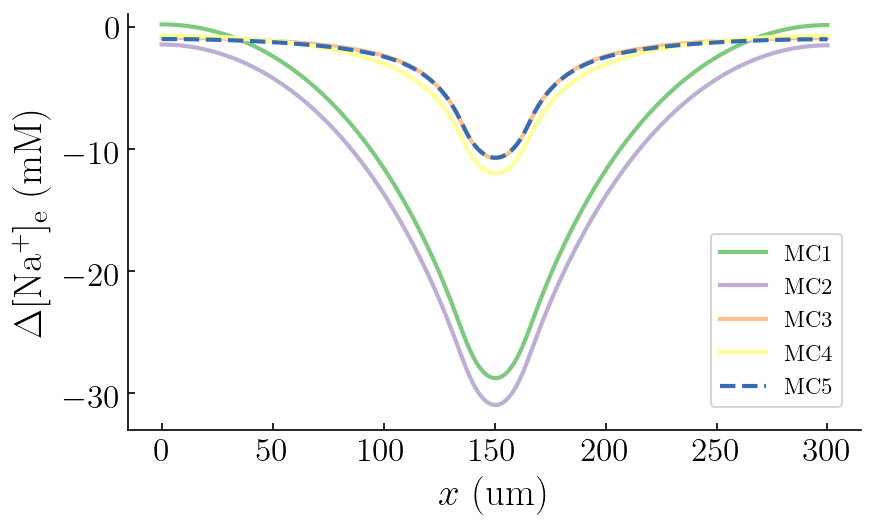

In [136]:
ylabel = r'$\Delta [\mathrm{Na^{+}}]_\mathrm{e}$ (mM)'
legend = ['MC1', 'MC2', 'MC3', 'MC4', 'MC5']


fig = plt.figure(figsize=(7*fs, 4*fs))
ax = plt.gca()
for i, line in enumerate(plot_list_dNae):
    linestyle = '--' if i==4  else '-'
    df.plot(line, color=color_list[i], label=legend[i], linestyle = linestyle, linewidth=lw)
if len(plot_list_dNai) > 1:
    legend = plt.legend(loc='upper right', prop={'size': 11})  # Adjust the legend's font size
    legend.set_bbox_to_anchor((0.99, 0.5))  # Adjust the legend's position
    legend.set_frame_on(True)  # Turn the legend's frame on
    # plt.figlegend(bbox_to_anchor=(0.9, 0.65), frameon=True)
plt.ylim([-33, 1])
plt.xticks(xticks, xticklabels)
plt.ylabel(ylabel, fontsize=fosi)
plt.xlabel(xlabel_x, fontsize=fosi)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

figname = 'mc1vmc5_deltaNae_space'
#save fig as pdf 
fig.savefig('results/figures/' + figname + '.pdf', format='pdf', bbox_inches='tight')

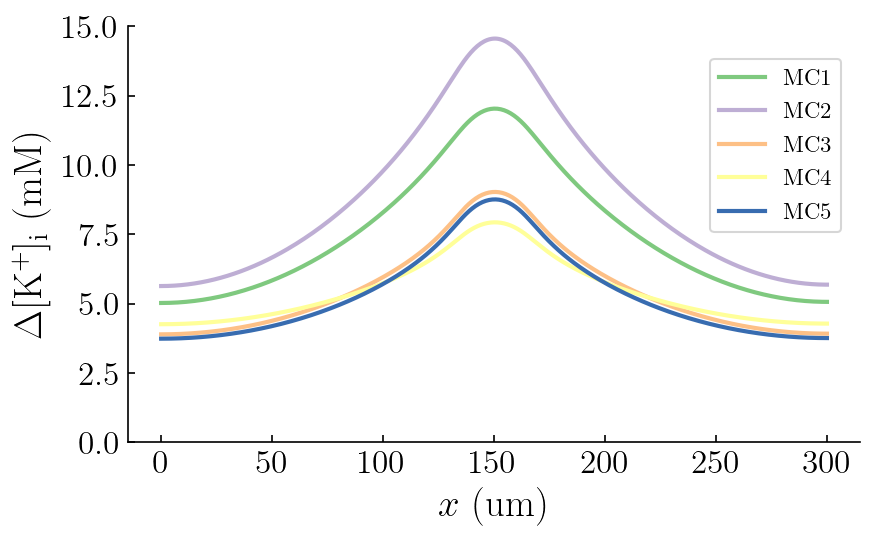

In [137]:
ylabel = r'$\Delta [\mathrm{K^{+}}]_\mathrm{i}$ (mM)'
legend = ['MC1', 'MC2', 'MC3', 'MC4', 'MC5']


fig = plt.figure(figsize=(7*fs, 4*fs))
ax = plt.gca()
for i, line in enumerate(plot_list_dKi):
    df.plot(line, color=color_list[i], label=legend[i], linewidth=lw)
if len(plot_list_dNai) > 1:
    legend = plt.legend(loc='upper right', prop={'size': 11})  # Adjust the legend's font size
    legend.set_bbox_to_anchor((0.99, 0.95))  # Adjust the legend's position
    legend.set_frame_on(True)  # Turn the legend's frame on
    # plt.figlegend(bbox_to_anchor=(0.9, 0.65), frameon=True)
    
    
plt.ylim([0, 15])

plt.xticks(xticks, xticklabels)
plt.ylabel(ylabel, fontsize=fosi)
plt.xlabel(xlabel_x, fontsize=fosi)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

figname = 'mc1vmc5_deltaKi_space'
#save fig as pdf 
fig.savefig('results/figures/' + figname + '.pdf', format='pdf', bbox_inches='tight')

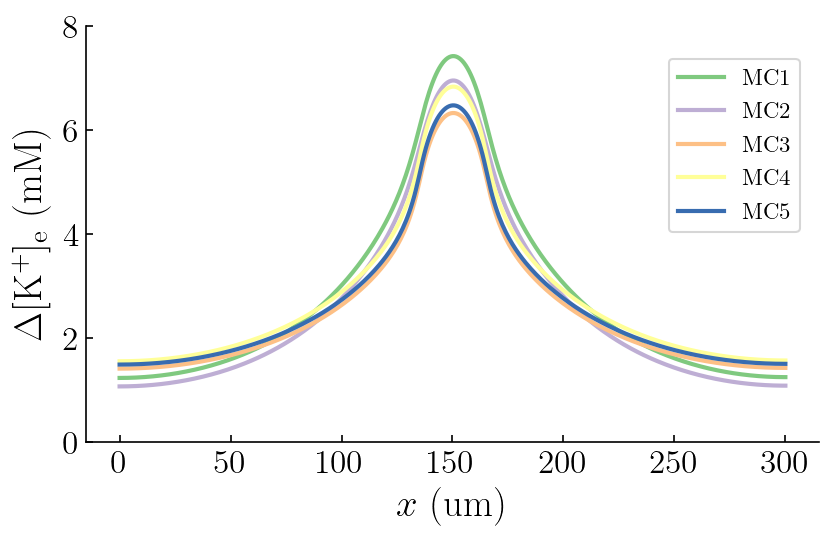

In [138]:
ylabel = r'$\Delta [\mathrm{K^{+}}]_\mathrm{e}$ (mM)'
legend = ['MC1', 'MC2', 'MC3', 'MC4', 'MC5']


fig = plt.figure(figsize=(7*fs, 4*fs))
ax = plt.gca()
for i, line in enumerate(plot_list_dKe):
    linestyle = '--' if i==3  else '-'
    df.plot(line, color=color_list[i], label=legend[i],linewidth=lw)
if len(plot_list_dNai) > 1:
    legend = plt.legend(loc='upper right', prop={'size': 11})  # Adjust the legend's font size
    legend.set_bbox_to_anchor((0.99, 0.95))  # Adjust the legend's position
    legend.set_frame_on(True)  # Turn the legend's frame on
    # plt.figlegend(bbox_to_anchor=(0.9, 0.65), frameon=True)
plt.ylim([0, 8])
plt.xticks(xticks, xticklabels)
plt.ylabel(ylabel, fontsize=fosi)
plt.xlabel(xlabel_x, fontsize=fosi)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

figname = 'mc1vmc5_deltaKe_space'
#save fig as pdf 
fig.savefig('results/figures/' + figname + '.pdf', format='pdf', bbox_inches='tight')

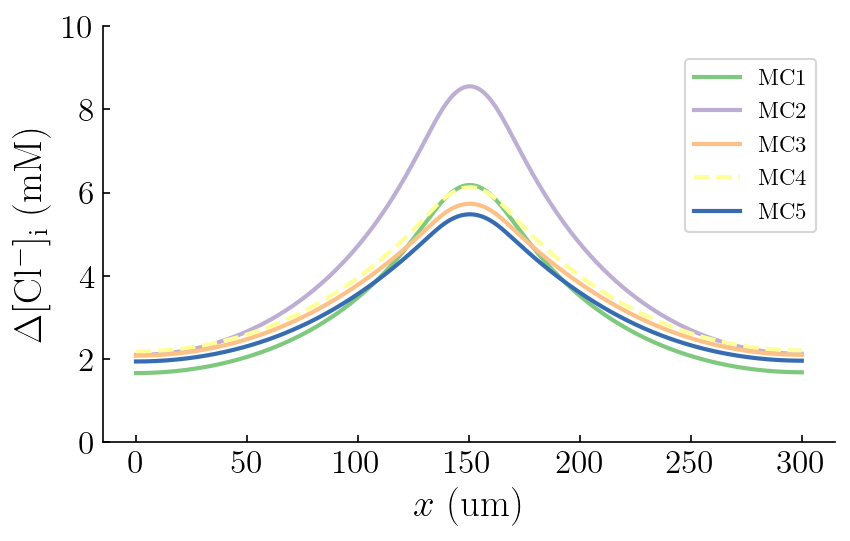

In [139]:
ylabel = r'$\Delta [\mathrm{Cl^{-}}]_\mathrm{i}$ (mM)'
legend = ['MC1', 'MC2', 'MC3', 'MC4', 'MC5']

lw = 2
fig = plt.figure(figsize=(7*fs, 4*fs))
ax = plt.gca()
for i, line in enumerate(plot_list_dCli):
    linestyle = '--' if i==3  else '-'
    df.plot(line, color=color_list[i], label=legend[i], linestyle = linestyle, linewidth=lw)
if len(plot_list_dNai) > 1:
    legend = plt.legend(loc='upper right', prop={'size': 11})  # Adjust the legend's font size
    legend.set_bbox_to_anchor((0.99, 0.95))  # Adjust the legend's position
    legend.set_frame_on(True)  # Turn the legend's frame on
    # plt.figlegend(bbox_to_anchor=(0.9, 0.65), frameon=True)
    
    
plt.ylim([0, 10])

plt.xticks(xticks, xticklabels)
plt.ylabel(ylabel, fontsize=fosi)
plt.xlabel(xlabel_x, fontsize=fosi)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

figname = 'mc1vmc5_deltaCli_space'
#save fig as pdf 
fig.savefig('results/figures/' + figname + '.pdf', format='pdf', bbox_inches='tight')

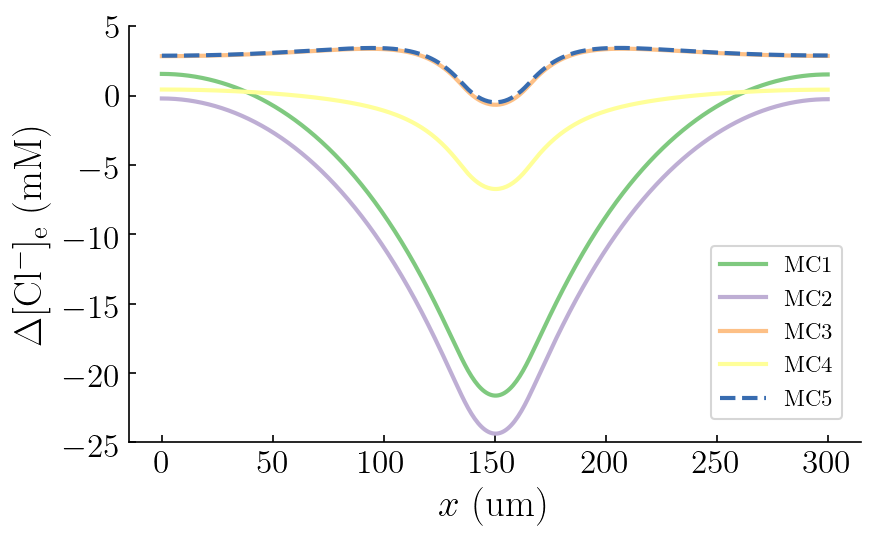

In [140]:
ylabel = r'$\Delta [\mathrm{Cl^{-}}]_\mathrm{e}$ (mM)'
legend = ['MC1', 'MC2', 'MC3', 'MC4', 'MC5']

lw = 2
fig = plt.figure(figsize=(7*fs, 4*fs))
ax = plt.gca()
for i, line in enumerate(plot_list_dCle):
    linestyle = '--' if i==4  else '-'
    df.plot(line, color=color_list[i], label=legend[i], linestyle = linestyle, linewidth=lw)
if len(plot_list_dNai) > 1:
    legend = plt.legend(loc='upper right', prop={'size': 11})  # Adjust the legend's font size
    legend.set_bbox_to_anchor((0.99, 0.5))  # Adjust the legend's position
    legend.set_frame_on(True)  # Turn the legend's frame on
    # plt.figlegend(bbox_to_anchor=(0.9, 0.65), frameon=True)
    
    
plt.ylim([-25, 5])

plt.xticks(xticks, xticklabels)
plt.ylabel(ylabel, fontsize=fosi)
plt.xlabel(xlabel_x, fontsize=fosi)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

figname = 'mc1vmc5_deltaCle_space'
#save fig as pdf 
fig.savefig('results/figures/' + figname + '.pdf', format='pdf', bbox_inches='tight')

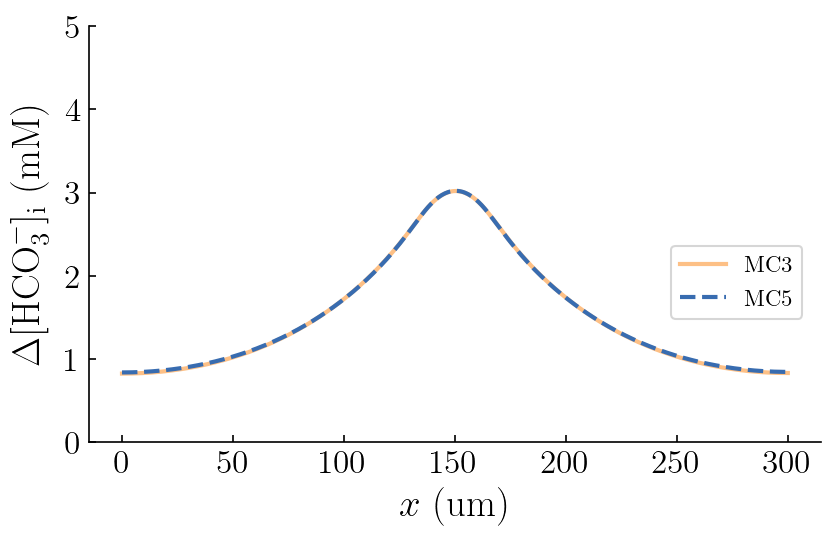

In [141]:
ylabel = r'$\Delta [\mathrm{HCO}_{3}^{-}]_\mathrm{i}$ (mM)'
legend = ['MC3', 'MC5']

color_list = [b2, b4]

lw = 2
fig = plt.figure(figsize=(7*fs, 4*fs))
ax = plt.gca()
for i, line in enumerate(plot_list_dHCO3i):
    linestyle = '--' if i==1  else '-'
    df.plot(line, color=color_list[i], label=legend[i], linestyle = linestyle, linewidth=lw)
if len(plot_list_dNai) > 1:
    legend = plt.legend(loc='upper right', prop={'size': 11})  # Adjust the legend's font size
    legend.set_bbox_to_anchor((0.99, 0.5))  # Adjust the legend's position
    legend.set_frame_on(True)  # Turn the legend's frame on
    # plt.figlegend(bbox_to_anchor=(0.9, 0.65), frameon=True)
    
    
plt.ylim([0, 5])

plt.xticks(xticks, xticklabels)
plt.ylabel(ylabel, fontsize=fosi)
plt.xlabel(xlabel_x, fontsize=fosi)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

figname = 'mc1vmc5_deltaHCO3i_space'
#save fig as pdf 
fig.savefig('results/figures/' + figname + '.pdf', format='pdf', bbox_inches='tight')

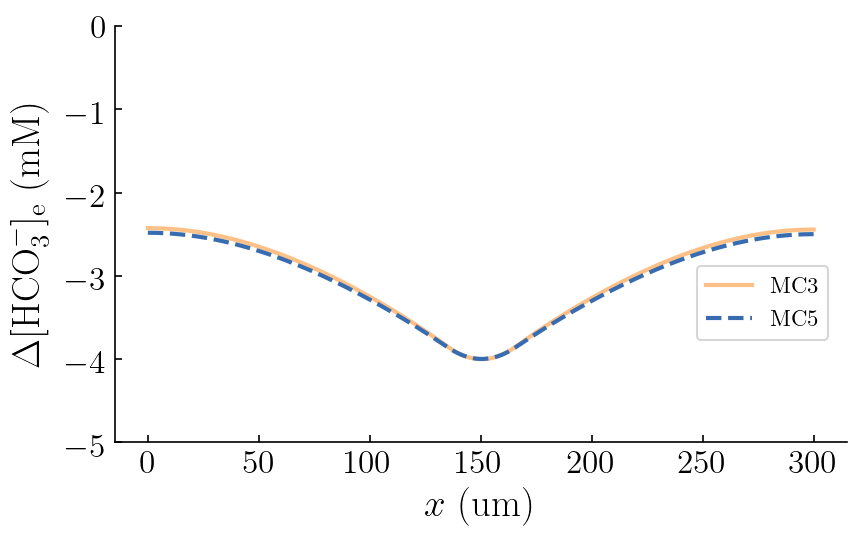

In [142]:
ylabel = r'$\Delta [\mathrm{HCO}_{3}^{-}]_\mathrm{e}$ (mM)'
legend = ['MC3', 'MC5']
color_list = [b2, b4]

lw = 2
fig = plt.figure(figsize=(7*fs, 4*fs))
ax = plt.gca()
for i, line in enumerate(plot_list_dHCO3e):
    linestyle = '--' if i==1  else '-'
    df.plot(line, color=color_list[i], label=legend[i], linestyle = linestyle, linewidth=lw)
if len(plot_list_dNai) > 1:
    legend = plt.legend(loc='upper right', prop={'size': 11})  # Adjust the legend's font size
    legend.set_bbox_to_anchor((0.99, 0.45))  # Adjust the legend's position
    legend.set_frame_on(True)  # Turn the legend's frame on
    # plt.figlegend(bbox_to_anchor=(0.9, 0.65), frameon=True)
    
    
plt.ylim([-5, 0])

plt.xticks(xticks, xticklabels)
plt.ylabel(ylabel, fontsize=fosi)
plt.xlabel(xlabel_x, fontsize=fosi)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

figname = 'mc1vmc5_deltaHCO3e_space'
#save fig as pdf 
fig.savefig('results/figures/' + figname + '.pdf', format='pdf', bbox_inches='tight')

# Fluid velocities 

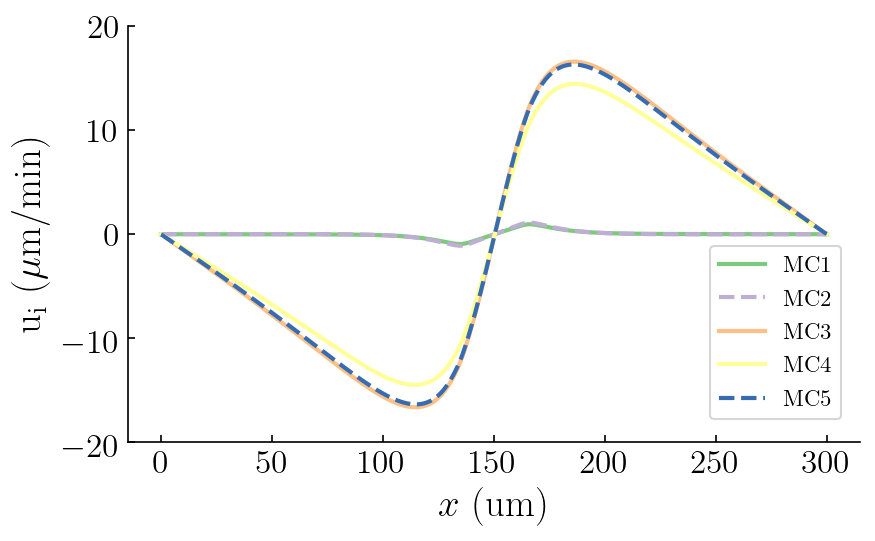

In [143]:
plot_list_u_i = [MC1.u_i_tot, MC2.u_i_tot, MC3.u_i_tot, MC4.u_i_tot, MC5.u_i_tot]
plot_list_u_e = [MC1.u_e_tot, MC2.u_e_tot, MC3.u_e_tot, MC4.u_e_tot, MC5.u_e_tot]

ylabel = r'$\mathrm{u}_\mathrm{i}$ ($\mu$m/min)'
legend = ['MC1', 'MC2', 'MC3', 'MC4', 'MC5']

b0 = '#7fc97fff'
b1 = '#beaed4ff'
b2 = '#fdc086ff'
b3 = '#ffff99ff'
b4 = '#386cb0ff'

color_list = [b0, b1, b2, b3, b4]

fig = plt.figure(figsize=(7*fs, 4*fs))
ax = plt.gca()
for i, line in enumerate(plot_list_u_i):
    linestyle = '--' if i==1 or i==4  else '-'
    df.plot(line, color=color_list[i], label=legend[i], linestyle = linestyle, linewidth=lw)
if len(plot_list_u_i) > 1:
    legend = plt.legend(loc='upper right', prop={'size': 11})  # Adjust the legend's font size
    legend.set_bbox_to_anchor((0.99, 0.5))  # Adjust the legend's position
    legend.set_frame_on(True)  # Turn the legend's frame on
    # plt.figlegend(bbox_to_anchor=(0.9, 0.65), frameon=True)
plt.ylim([-20, 20])
plt.xticks(xticks, xticklabels)
plt.ylabel(ylabel, fontsize=fosi)
plt.xlabel(xlabel_x, fontsize=fosi)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

figname = 'mc1vmc5_ui_space'
#save fig as pdf 
fig.savefig('results/figures/' + figname + '.pdf', format='pdf', bbox_inches='tight')

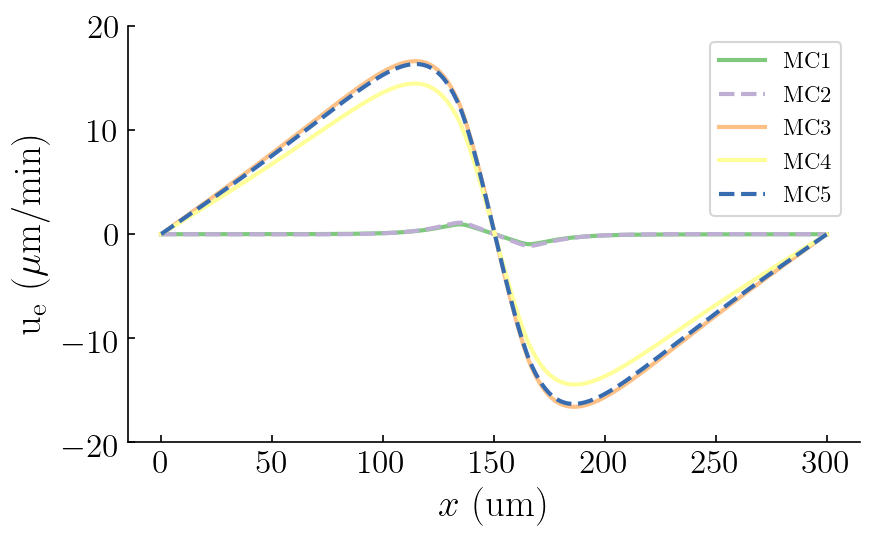

In [145]:
plot_list_u_i = [MC1.u_i_tot, MC2.u_i_tot, MC3.u_i_tot, MC4.u_i_tot, MC5.u_i_tot]
plot_list_u_e = [MC1.u_e_tot, MC2.u_e_tot, MC3.u_e_tot, MC4.u_e_tot, MC5.u_e_tot]

ylabel = r'$\mathrm{u}_\mathrm{e}$ ($\mu$m/min)'
legend = ['MC1', 'MC2', 'MC3', 'MC4', 'MC5']

b0 = '#7fc97fff'
b1 = '#beaed4ff'
b2 = '#fdc086ff'
b3 = '#ffff99ff'
b4 = '#386cb0ff'

color_list = [b0, b1, b2, b3, b4]

fig = plt.figure(figsize=(7*fs, 4*fs))
ax = plt.gca()
for i, line in enumerate(plot_list_u_e):
    linestyle = '--' if i==1 or i==4  else '-'
    df.plot(line, color=color_list[i], label=legend[i], linestyle = linestyle, linewidth=lw)
if len(plot_list_u_i) > 1:
    legend = plt.legend(loc='upper right', prop={'size': 11})  # Adjust the legend's font size
    legend.set_bbox_to_anchor((0.99, 0.99))  # Adjust the legend's position
    legend.set_frame_on(True)  # Turn the legend's frame on
    # plt.figlegend(bbox_to_anchor=(0.9, 0.65), frameon=True)
plt.ylim([-20, 20])
plt.xticks(xticks, xticklabels)
plt.ylabel(ylabel, fontsize=fosi)
plt.xlabel(xlabel_x, fontsize=fosi)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


figname = 'mc1vmc5_ue_space'
#save fig as pdf 
fig.savefig('results/figures/' + figname + '.pdf', format='pdf', bbox_inches='tight')

Plotting different combinations of models for comparison.

# Plot hydrostatic, osmotic and electro-osmotic fluid velocities.

In [28]:
plot_list_MC3_ui_comp = [MC3.u_i_hyd, MC3.u_i_osm, MC3.u_i_tot]
plot_list_MC5_ui_comp = [MC5.u_i_hyd, MC5.u_i_osm, MC5.u_i_tot]
plot_list_MC3_ui_comp = [MC3.u_i_hyd, MC3.u_i_osm, MC3.u_i_tot]
plot_list_MC2_ui_comp = [MC2.u_i_hyd, MC2.u_i_osm, MC2.u_i_tot]
plot_list_MC1_ui_comp = [MC1.u_i_hyd, MC1.u_i_osm, MC1.u_i_tot]

plot_list_MC3_ue_comp = [MC3.u_e_hyd, MC3.u_e_eof, MC3.u_e_tot]
plot_list_MC5_ue_comp = [MC5.u_e_hyd, MC5.u_e_eof, MC5.u_e_tot]
plot_list_MC2_ue_comp = [MC2.u_e_hyd, MC2.u_e_eof, MC2.u_e_tot]
plot_list_MC1_ue_comp = [MC1.u_e_hyd, MC1.u_e_eof, MC1.u_e_tot]
plot_list_MC4_ue_comp = [MC4.u_e_hyd, MC4.u_e_eof, MC4.u_e_tot]

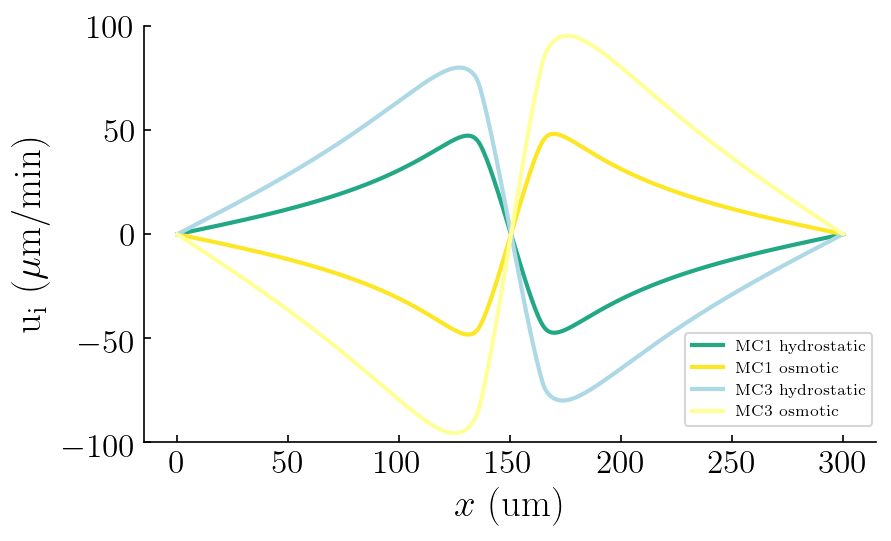

In [146]:
plot_list_MC1_MC3_ui_components = [MC1.u_i_hyd, MC1.u_i_osm, MC3.u_i_hyd, MC3.u_i_osm]

ylabel = r'$\mathrm{u}_\mathrm{i}$ ($\mu$m/min)'
# legend = ['MC1', 'MC2', 'MC3', 'MC4', 'MC5']
legend = ['MC1 hydrostatic', 'MC1 osmotic', 'MC3 hydrostatic', 'MC3 osmotic']
# b2 = '#fdc086ff' 
# b4 = '#386cb0ff'
# color_list = [b2,b4]
mc1_hydro = c3
mc1_osm = c5
#dark yellow for MC3 hydrostatic
mc3_osm = '#ffff99ff'
#slightly darker blue for MC3 osmotic
mc3_hydro = '#ADD8E6'
color_list = [mc1_hydro, mc1_osm, mc3_hydro, mc3_osm]

fig = plt.figure(figsize=(7*fs, 4*fs))
ax = plt.gca()
for i, line in enumerate(plot_list_MC1_MC3_ui_components):
    linestyle = '--' if i==2  else '-'
    df.plot(line, color=color_list[i], label=legend[i], linewidth=lw)
if len(plot_list_u_i) > 1:
    legend = plt.legend(loc='upper right', prop={'size': 7.5})  # Adjust the legend's font size
    legend.set_bbox_to_anchor((1.005, 0.28))  # Adjust the legend's position
    legend.set_frame_on(True)  # Turn the legend's frame on
    # plt.figlegend(bbox_to_anchor=(0.9, 0.65), frameon=True)
plt.ylim([-100, 100])
plt.xticks(xticks, xticklabels)
plt.ylabel(ylabel, fontsize=fosi)
plt.xlabel(xlabel_x, fontsize=fosi)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

figname = 'mc1vmc3_osm_hyd_comparison'
#save fig as pdf 
fig.savefig('results/figures/' + figname + '.pdf', format='pdf', bbox_inches='tight')

Printing out maximal fluid velocities for each compartment and model:

In [15]:
#print maximal total ICS fluid velocity 
max_u_i_MC1 = np.max(MC1.u_i_tot.vector().get_local())
max_u_i_MC2 = np.max(MC2.u_i_tot.vector().get_local())
max_u_i_MC3 = np.max(MC3.u_i_tot.vector().get_local())
max_u_i_MC4 = np.max(MC4.u_i_tot.vector().get_local())
max_u_i_MC5 = np.max(MC5.u_i_tot.vector().get_local())

print('maximal total ICS fluid velocity MC1: ', max_u_i_MC1)
print('maximal total ICS fluid velocity MC2: ', max_u_i_MC2)
print('maximal total ICS fluid velocity MC3: ', max_u_i_MC3)
print('maximal total ICS fluid velocity MC4: ', max_u_i_MC4)
print('maximal total ICS fluid velocity MC5: ', max_u_i_MC5)
print("""""""""""""""""")

#print maximal total ICS fluid velocity 
max_u_e_MC1 = np.max(MC1.u_e_tot.vector().get_local())
max_u_e_MC2 = np.max(MC2.u_e_tot.vector().get_local())
max_u_e_MC3 = np.max(MC3.u_e_tot.vector().get_local())
max_u_e_MC4 = np.max(MC4.u_e_tot.vector().get_local())
max_u_e_MC5 = np.max(MC5.u_e_tot.vector().get_local())

print('maximal total ECS fluid velocity MC1: ', max_u_e_MC1)
print('maximal total ECS fluid velocity MC2: ', max_u_e_MC2)
print('maximal total ECS fluid velocity MC3: ', max_u_e_MC3)
print('maximal total ECS fluid velocity MC4: ', max_u_e_MC4)
print('maximal total ECS fluid velocity MC5: ', max_u_e_MC5)


maximal total ICS fluid velocity MC1:  0.9581984478288449
maximal total ICS fluid velocity MC2:  1.1222385305560674
maximal total ICS fluid velocity MC3:  16.603148963859415
maximal total ICS fluid velocity MC4:  14.461430226836269
maximal total ICS fluid velocity MC5:  16.327082866921483

maximal total ECS fluid velocity MC1:  0.9478219958034161
maximal total ECS fluid velocity MC2:  1.1073988348094341
maximal total ECS fluid velocity MC3:  16.64681908696429
maximal total ECS fluid velocity MC4:  14.49429964762354
maximal total ECS fluid velocity MC5:  16.370416749995574
